/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/cudf/utils/_ptxcompiler.py:64: UserWarning: Error getting driver and runtime versions:

stdout:



stderr:

Traceback (most recent call last):
  File "<string>", line 4, in <module>
  File "/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/jbac/miniforge3/envs/spatial/lib/python3.11/site-packages/numba_cuda/numba/cuda/cudadrv/driver.py", line 272, in __getattr__
    raise CudaSupportError("Error at driver init: \n%s:" %
numba.cuda.cudadrv.error.CudaSupportError: Error at driver init: 

CUDA driver library cannot be found.
If you are sure that a CUDA driver is installed,
try setting environment va

Removed 0  cells...
Removed 0  genes...
GPU not available. Switching to CPU backend...
Normalizing total counts...
Applying log1p transformation...
Performing PCA...
Performing UMAP...


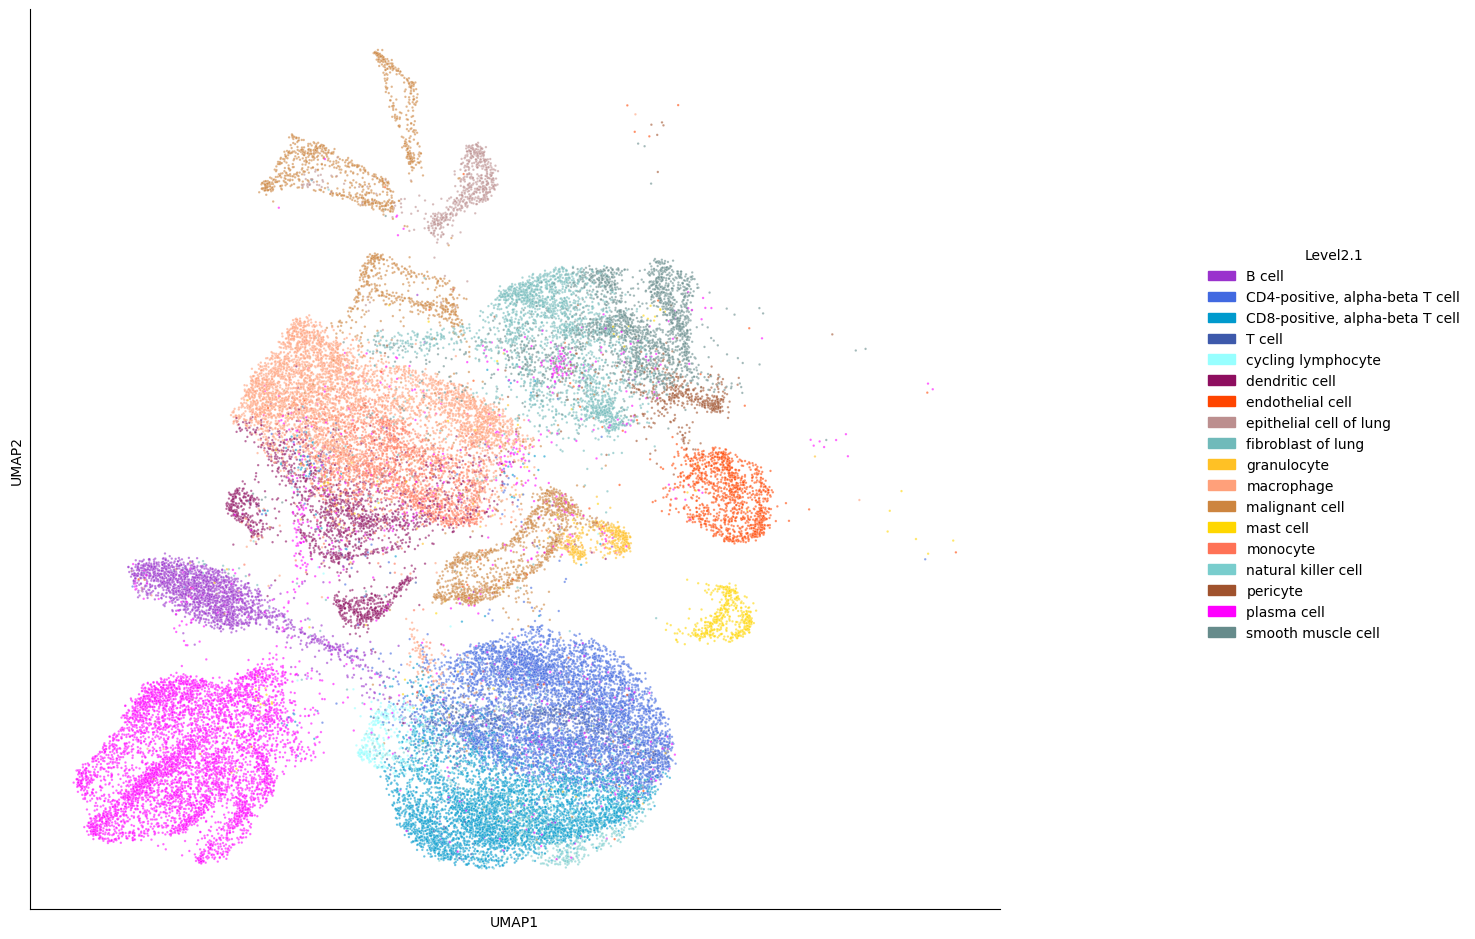

In [1]:
import dask

dask.config.set({"dataframe.query-planning": False})

import argparse
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path

import scanpy as sc
import sys
sys.path.append("../../scripts/")
import preprocessing
import readwrite
cfg = readwrite.config()

points_only = False
embed_file = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/results/embed_panel_scrnaseq_joint/matched_combo_standard_lung_specific_matched_combo_standard_breast_specific/umap_RNA_counts_n_comps=50_n_neighbors=50_min_dist=0.5_euclidean.parquet'
color='Level2.1'
cell_type_palette = '/work/PRTNR/CHUV/DIR/rgottar1/spatial/env/xenium_paper/data/xenium/metadata/col_palette_cell_types_combo.csv'
s = 3
alpha = 0.6
normalize = True
log1p = True
n_comps = 50
metric = 'euclidean'
min_dist = 0.5
n_neighbors = 50


# cfg paths
results_dir = Path(cfg['results_dir'])
scrnaseq_processed_data_dir = Path(cfg['scrnaseq_processed_data_dir'])
seurat_to_h5_dir = results_dir / 'seurat_to_h5'

reference1 = scrnaseq_processed_data_dir / 'matched_combo_standard_lung_specific'
reference1_name = reference1.stem
reference1_dir = seurat_to_h5_dir / reference1_name
reference1_is_done = reference1_dir / '.done'

reference2 = scrnaseq_processed_data_dir / 'matched_combo_standard_breast_specific'
reference2_name = reference2.stem
reference2_dir = seurat_to_h5_dir / reference2_name
reference2_is_done = reference2_dir / '.done'



layer = 'RNA_counts'

ad1 = sc.read_10x_h5(reference1_dir / f"{layer}.h5")
ad2 = sc.read_10x_h5(reference2_dir / f"{layer}.h5")
ad_merge = sc.concat([ad1, ad2])
idx = np.unique(ad_merge.obs_names, return_index=True)[1]
ad_merge = ad_merge[idx].copy()


preprocessing.preprocess(
    ad_merge,
    normalize=normalize,
    log1p=log1p,
    scale="none",
    n_comps=n_comps,
    metric=metric,
    min_dist=min_dist,
    n_neighbors=n_neighbors,
    pca=True,
    umap=True,
    save_raw=False,
    min_counts=None,
    min_genes=None,
    max_counts=None,
    max_genes=None,
    min_cells=None,
)





if color == "sample":
    palette = pd.read_csv(sample_palette, index_col=0).iloc[:, 0]
elif color == "panel":
    palette = pd.read_csv(panel_palette, index_col=0).iloc[:, 0]
else:
    if color == "Level2.1":
        palette_lvl2 = (
            pd.read_csv(cell_type_palette)[["Level2", "cols_Level2"]].drop_duplicates().set_index("Level2").squeeze()
        )
        palette = pd.read_csv(cell_type_palette)[[color, f"cols_{color}"]].drop_duplicates().set_index(color).squeeze()
        for k, v in palette_lvl2.items():
            if k not in palette.index:
                palette[k] = palette_lvl2[k]
    else:
        palette = pd.read_csv(cell_type_palette)[[color, f"cols_{color}"]].drop_duplicates().set_index(color).squeeze()



df = pd.DataFrame(ad_merge.obsm["X_umap"], index=ad_merge.obs_names, columns=["UMAP1", "UMAP2"])


df["cell_id"] = df.index
annot1 = pd.read_parquet(reference1_dir / "metadata.parquet").set_index("cell_id")[color]
annot2 = pd.read_parquet(reference1_dir / "metadata.parquet").set_index("cell_id")[color]
annot = pd.concat((annot1, annot2), axis=0)
annot = annot[~annot.index.duplicated(keep='first')]
df = df.join(annot).dropna()

if color == "Level2.1":
    name_malignant = "malignant cell"

    ct_to_replace = df[color][df[color].str.contains("malignant cell")].unique()
    replace_map = dict([[ct, name_malignant] for ct in ct_to_replace])
    df[color] = df[color].replace(replace_map)

    palette[name_malignant] = palette_lvl2["malignant cell of lung"]

# plotting color, palette
unique_labels = np.unique(df[color].dropna())
palette = {u: palette[u] for u in unique_labels}
legend_handles = [mpatches.Patch(color=color, label=label) for label, color in palette.items()]


# plot
figsize = (10, 10) if points_only else (12, 10)
f = plt.figure(figsize=figsize)
ax = plt.subplot()

sns.scatterplot(
    data=df,
    x="UMAP1",
    y="UMAP2",
    s=s,
    alpha=alpha,
    hue=color,
    ax=ax,
    palette=palette,
    legend=False,
)

if not points_only:
    ax.xaxis.set_ticks([])
    ax.yaxis.set_ticks([])
    sns.despine()

    f.legend(
        handles=legend_handles,
        loc="center left",
        bbox_to_anchor=(1, 0.5),
        title=color if isinstance(color, str) else ", ".join(color),
        frameon=False,
    )
    plt.tight_layout(rect=[0, 0, 0.85, 0.95])
else:
    ax.axis("off")